In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# import geopandas as gpd

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve,\
    make_scorer

In [2]:
df_test = pd.read_csv('data/test_set_values.csv')
df_test

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,2011-02-24,Danida,34,Da,38.852669,-6.582841,Kwambwezi,0,...,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
14846,18990,1000.0,2011-03-21,Hiap,0,HIAP,37.451633,-5.350428,Bonde La Mkondoa,0,...,annually,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
14847,28749,0.0,2013-03-04,NaN,1476,NaN,34.739804,-4.585587,Bwawani,0,...,never pay,soft,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe
14848,33492,0.0,2013-02-18,Germany,998,DWE,35.432732,-10.584159,Kwa John,0,...,never pay,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe


In [3]:
df_train = pd.read_csv('data/training_set_values.csv')
df_train

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [4]:
df_train_label = pd.read_csv('data/training_set_labels.csv')
df_train_label.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [5]:
df_train_label['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [6]:
target = df_train_label.replace({'status_group': {'functional' : 1, 
                                'non functional' : 0, 
                                'functional needs repair' : 0}})
target['status_group'].value_counts()

1    32259
0    27141
Name: status_group, dtype: int64

In [7]:
df = pd.concat([df_train, target], axis=1)
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,id,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,69572,1
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,8776,1
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,34310,1
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,67743,0
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,19728,1


In [8]:
col_to_delete = ['id', 'recorded_by', 'funder', 'public_meeting',
                'lga', 'ward', 'region_code', 'district_code', 
                 'wpt_name','scheme_name', 'extraction_type', 'extraction_type_group',
                 'payment', 'quality_group', 'source_type', 'quantity_group',
                 'waterpoint_type_group', 'subvillage', 'num_private']
                 
df2 = df.drop(col_to_delete, axis=1)
df2.head()

,amount_tsh,date_recorded,gps_height,installer,longitude,latitude,basin,region,population,scheme_management,...,extraction_type_class,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,status_group
0,6000.0,2011-03-14,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,109,VWC,...,gravity,vwc,user-group,annually,soft,enough,spring,groundwater,communal standpipe,1
1,0.0,2013-03-06,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,280,Other,...,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,1
2,25.0,2013-02-25,686,World vision,37.460664,-3.821329,Pangani,Manyara,250,VWC,...,gravity,vwc,user-group,per bucket,soft,enough,dam,surface,communal standpipe multiple,1
3,0.0,2013-01-28,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,58,VWC,...,submersible,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,0
4,0.0,2011-07-13,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,0,NaN,...,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,1


In [9]:
print(df2.shape)

(59400, 22)


In [10]:
print(df2.duplicated().value_counts())

df2.drop_duplicates(keep='first',inplace=True)

False    58579
True       821
dtype: int64


C:\Users\Jun\AppData\Local\Temp/ipykernel_31248/4267668348.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop_duplicates(keep='first',inplace=True)


In [11]:
df2.shape

(58579, 22)

In [12]:
df2 = df2.dropna(axis = 0)
df2.shape

(50545, 22)

In [13]:
df2['year_recorded'] = [int(val[0:4]) for val in df2['date_recorded']]
df2['year_recorded'].astype(np.int64)
df2.drop(['date_recorded'], axis='columns', inplace=True)
df2.head()

,amount_tsh,gps_height,installer,longitude,latitude,basin,region,population,scheme_management,permit,...,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,status_group,year_recorded
0,6000.0,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,109,VWC,False,...,vwc,user-group,annually,soft,enough,spring,groundwater,communal standpipe,1,2011
1,0.0,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,280,Other,True,...,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,1,2013
2,25.0,686,World vision,37.460664,-3.821329,Pangani,Manyara,250,VWC,True,...,vwc,user-group,per bucket,soft,enough,dam,surface,communal standpipe multiple,1,2013
3,0.0,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,58,VWC,True,...,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,0,2013
5,20.0,0,DWE,39.172796,-4.765587,Pangani,Tanga,1,VWC,True,...,vwc,user-group,per bucket,salty,enough,other,unknown,communal standpipe multiple,1,2011


In [14]:
df2['construction_year'] = ['unknown' if val == 0 
                           else str((val // 10) * 10) for val in df2['construction_year']]
df2['construction_year'].value_counts()

unknown    16240
2000       13800
1990        6420
1980        4993
2010        4519
1970        4113
1960         460
Name: construction_year, dtype: int64

In [15]:
scheme_management_list = ['SWC', 'Trust', 'None']
df2['scheme_management'].replace(scheme_management_list, 'Other', inplace=True)
df2['scheme_management'].value_counts()

VWC                 33542
WUG                  4539
Water authority      2942
WUA                  2656
Water Board          2527
Parastatal           1490
Private operator     1042
Company              1032
Other                 775
Name: scheme_management, dtype: int64

In [16]:
installer_list = ['DWE', 'Government', 'Commu', 'DANIDA', 
                  'RWE', 'KKKT', 'TCRS']
df2['installer'] = ['Other' if val not in installer_list 
                           else val for val in df2['installer']]
df2['installer'].value_counts()

Other         29476
DWE           14690
Government     1686
Commu          1060
DANIDA         1046
RWE            1025
KKKT            889
TCRS            673
Name: installer, dtype: int64

In [17]:
df2.drop(df2.index[df2['year_recorded'] == 2004], inplace=True)
df2.drop(df2.index[df2['year_recorded'] == 2002], inplace=True)
df2['year_recorded'].value_counts()

2011    24399
2013    20794
2012     5326
Name: year_recorded, dtype: int64

In [18]:
df2.reset_index(inplace=True, drop=True)
df2.head()

,amount_tsh,gps_height,installer,longitude,latitude,basin,region,population,scheme_management,permit,...,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,status_group,year_recorded
0,6000.0,1390,Other,34.938093,-9.856322,Lake Nyasa,Iringa,109,VWC,False,...,vwc,user-group,annually,soft,enough,spring,groundwater,communal standpipe,1,2011
1,0.0,1399,Other,34.698766,-2.147466,Lake Victoria,Mara,280,Other,True,...,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,1,2013
2,25.0,686,Other,37.460664,-3.821329,Pangani,Manyara,250,VWC,True,...,vwc,user-group,per bucket,soft,enough,dam,surface,communal standpipe multiple,1,2013
3,0.0,263,Other,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,58,VWC,True,...,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,0,2013
4,20.0,0,DWE,39.172796,-4.765587,Pangani,Tanga,1,VWC,True,...,vwc,user-group,per bucket,salty,enough,other,unknown,communal standpipe multiple,1,2011


In [19]:
def num_encoder(df_to_encode):
    ss = StandardScaler()

    ss.fit(df_to_encode)
    nums_df = pd.DataFrame(ss.transform(df_to_encode),
                           columns=df_to_encode.columns,
                          index=df_to_encode.index)
    return nums_df

def cat_encoder(df_to_encode):
    ohe = OneHotEncoder(
        drop='first',
        sparse=False)
    
    dums = ohe.fit_transform(df_to_encode)
    dums_df = pd.DataFrame(dums,
                            columns=ohe.get_feature_names(),
                            index=df_to_encode.index)
    return dums_df

In [20]:
y = df2.status_group
X = df2.drop('status_group', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

In [21]:
X_train_cat = X_train.select_dtypes('object')
X_train_nums = X_train.select_dtypes(['float64', 'int64'])

X_test_cat = X_test.select_dtypes('object')
X_test_nums = X_test.select_dtypes(['float64', 'int64'])

X_train_cat.shape, X_train_nums.shape, X_test_cat.shape, X_test_nums.shape

((37889, 15), (37889, 6), (12630, 15), (12630, 6))

In [22]:
cont_pipeline = Pipeline(steps=[
    ('ss', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first'))
])

trans = ColumnTransformer(transformers=[
    ('continuous', cont_pipeline, X_train_nums.columns),
    ('categorical', cat_pipeline, X_train_cat.columns)
])

dummy = Pipeline(steps=[
    ('trans', trans),
    ('dummy', DummyClassifier(random_state = 69, strategy = 'most_frequent'))
])

#Fitting and checking the score
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.5461215656259073

In [23]:
X_train_clean = pd.concat([num_encoder(X_train_nums), cat_encoder(X_train_cat)], axis=1)
X_test_clean = pd.concat([num_encoder(X_test_nums), cat_encoder(X_test_cat)], axis=1)

In [24]:
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, \
AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

In [25]:
decision_tree = DecisionTreeClassifier(random_state = 69)
decision_tree.fit(X_train_clean, y_train)

DecisionTreeClassifier(random_state=69)

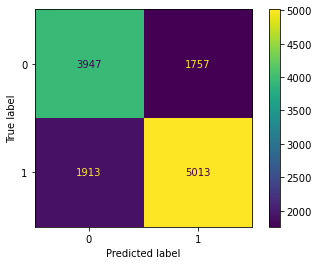

In [26]:
y_tree_train = decision_tree.predict(X_train_clean)
y_tree_test = decision_tree.predict(X_test_clean)
plot_confusion_matrix(decision_tree, X_test_clean, y_test);

In [27]:
display(accuracy_score(y_train, y_tree_train))
display(accuracy_score(y_test, y_tree_test))


0.9972287471297738

0.7094220110847189

In [28]:
display(precision_score(y_train, y_tree_train))

display(precision_score(y_test, y_tree_test))

0.99854700440742

0.7404726735598227

In [29]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_clean, y_train)

DecisionTreeClassifier()

In [30]:
param_dict = {
    "criterion":['gini', 'entropy'],
    "max_depth":[1, 10, 25, 50],
    "min_samples_split":range(1,10),
    "min_samples_leaf":range(1,10)
}

In [31]:

tw = GridSearchCV(estimator=decision_tree,
                 param_grid=param_dict,
                 cv=5,
                 verbose=1,
                 n_jobs=-1)
tw.fit(X_train_clean, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  1.8min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 10, 25, 50],
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(1, 10)},
             verbose=1)

In [32]:
tw.best_params_

{'criterion': 'gini',
 'max_depth': 25,
 'min_samples_leaf': 7,
 'min_samples_split': 2}

Kept getting different `min_samples_split` value without results changing so it seems `criterion`, `max_depth`, & and `min_samples_leaf` give us a consistent enough result that `min_samples_split` does not need to be manipulated by us.

In [33]:
tw.best_score_

0.7821003388698411

In [34]:
decision_tree_better = DecisionTreeClassifier(random_state = 69, criterion = 'gini', max_depth = 25, 
                                              min_samples_leaf = 7)
decision_tree_better.fit(X_train_clean, y_train)

DecisionTreeClassifier(max_depth=25, min_samples_leaf=7, random_state=69)

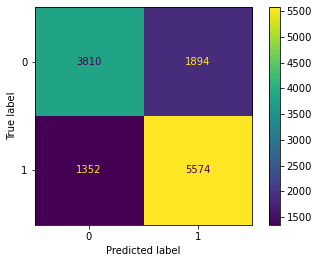

In [35]:
y_tree_train_better = decision_tree_better.predict(X_train_clean)
y_tree_test_better = decision_tree_better.predict(X_test_clean)
plot_confusion_matrix(decision_tree_better, X_test_clean, y_test);

In [36]:
display(accuracy_score(y_train, y_tree_train_better))
display(accuracy_score(y_test, y_tree_test_better))


0.8751616564174298

0.7429928741092636

In [37]:
display(precision_score(y_train, y_tree_train_better))
display(precision_score(y_test, y_tree_test_better))

0.8781030888762554

0.7463845741831816

In [39]:
# y_tt_clean = decision_tree_better.predict(X_tt_clean)

[1.47931553e-02 7.06741109e-02 1.37656468e-01 1.36412583e-01
 4.72975568e-02 9.47132362e-03 1.26092158e-03 1.04345283e-02
 5.82382134e-03 9.06322625e-04 1.11648350e-02 3.04826653e-03
 1.21127390e-03 5.46059933e-03 3.39881379e-03 4.67336109e-03
 4.57236101e-03 5.56055577e-03 4.61039412e-03 4.53617833e-03
 4.65557022e-03 9.83371484e-04 2.48559917e-03 1.07936250e-02
 2.27313050e-03 2.68888885e-03 3.74842211e-03 1.47008911e-03
 2.52046233e-03 1.99306915e-03 2.60622003e-03 2.39630470e-03
 2.15336860e-03 2.11639063e-03 2.91419532e-03 2.25636505e-03
 2.40069646e-03 2.25817879e-03 1.34281473e-03 1.76783605e-03
 2.61609520e-03 1.42082360e-03 1.28316334e-03 1.54318564e-03
 6.72159799e-03 2.26075401e-03 2.71244723e-03 3.32086689e-03
 3.83829342e-03 1.44374732e-02 1.05299259e-02 7.16717668e-03
 7.71559113e-03 1.23514709e-02 1.21967897e-02 6.44013611e-03
 8.43652872e-03 3.89371212e-03 2.74402932e-02 7.32222546e-04
 7.46401096e-03 4.43057745e-04 7.67916598e-04 2.22014157e-04
 1.34117761e-03 2.687296

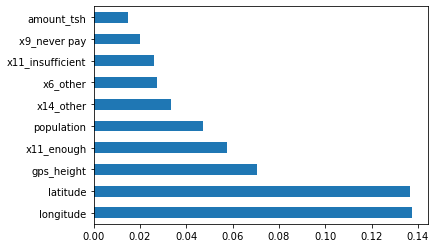

In [40]:
model = ExtraTreesClassifier()
model.fit(X_train_clean,y_train)

print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train_clean.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [41]:
logreg_clf = LogisticRegression(random_state=69)
logreg_model = logreg_clf.fit(X_train_clean, y_train)

C:\Users\Jun\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
logreg_train_pred = logreg_clf.predict(X_train_clean)
logreg_train_acc = accuracy_score(y_train, logreg_train_pred)

log_val_preds = logreg_clf.predict(X_test_clean) # y_hat
log_val_accuracy = accuracy_score(y_test, log_val_preds)

logreg_train_acc, log_val_accuracy

(0.7623584681569848, 0.7626286619160728)

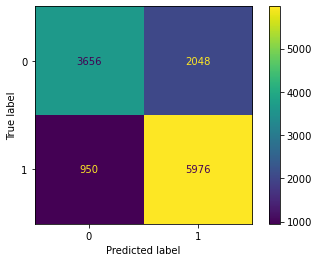

In [43]:
plot_confusion_matrix(logreg_clf, X_test_clean, y_test);

In [44]:
display(precision_score(y_train, logreg_train_pred))

display(precision_score(y_test, log_val_preds))

0.7454637096774194

0.744765702891326

In [45]:
col_to_delete = ['id', 'recorded_by', 'funder', 'public_meeting',
                'lga', 'ward', 'region_code', 'district_code', 
                 'wpt_name','scheme_name', 'extraction_type', 'extraction_type_group',
                 'payment', 'quality_group', 'source_type', 'quantity_group',
                 'waterpoint_type_group', 'subvillage', 'num_private']
                 
test_2 = df_test.drop(col_to_delete, axis=1)
test_2.head()

,amount_tsh,date_recorded,gps_height,installer,longitude,latitude,basin,region,population,scheme_management,...,construction_year,extraction_type_class,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type
0,0.0,2013-02-04,1996,DMDD,35.290799,-4.059696,Internal,Manyara,321,Parastatal,...,2012,other,parastatal,parastatal,never pay,soft,seasonal,rainwater harvesting,surface,other
1,0.0,2013-02-04,1569,DWE,36.656709,-3.309214,Pangani,Arusha,300,VWC,...,2000,gravity,vwc,user-group,never pay,soft,insufficient,spring,groundwater,communal standpipe
2,0.0,2013-02-01,1567,NaN,34.767863,-5.004344,Internal,Singida,500,VWC,...,2010,other,vwc,user-group,never pay,soft,insufficient,rainwater harvesting,surface,other
3,0.0,2013-01-22,267,FINN WATER,38.058046,-9.418672,Ruvuma / Southern Coast,Lindi,250,VWC,...,1987,other,vwc,user-group,unknown,soft,dry,shallow well,groundwater,other
4,500.0,2013-03-27,1260,BRUDER,35.006123,-10.950412,Ruvuma / Southern Coast,Ruvuma,60,Water Board,...,2000,gravity,water board,user-group,monthly,soft,enough,spring,groundwater,communal standpipe


In [46]:
print(test_2.duplicated().value_counts())

test_2.drop_duplicates(keep='first',inplace=True)

False    14749
True       101
dtype: int64


In [47]:
test_2.shape

(14749, 21)

In [48]:
test_2 = test_2.dropna(axis = 0)
test_2.shape

(12766, 21)

In [49]:
test_2['year_recorded'] = [int(val[0:4]) for val in test_2['date_recorded']]
test_2['year_recorded'].astype(np.int64)
test_2.drop(['date_recorded'], axis='columns', inplace=True)
test_2.head()

,amount_tsh,gps_height,installer,longitude,latitude,basin,region,population,scheme_management,permit,...,extraction_type_class,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,year_recorded
0,0.0,1996,DMDD,35.290799,-4.059696,Internal,Manyara,321,Parastatal,True,...,other,parastatal,parastatal,never pay,soft,seasonal,rainwater harvesting,surface,other,2013
1,0.0,1569,DWE,36.656709,-3.309214,Pangani,Arusha,300,VWC,True,...,gravity,vwc,user-group,never pay,soft,insufficient,spring,groundwater,communal standpipe,2013
3,0.0,267,FINN WATER,38.058046,-9.418672,Ruvuma / Southern Coast,Lindi,250,VWC,True,...,other,vwc,user-group,unknown,soft,dry,shallow well,groundwater,other,2013
4,500.0,1260,BRUDER,35.006123,-10.950412,Ruvuma / Southern Coast,Ruvuma,60,Water Board,True,...,gravity,water board,user-group,monthly,soft,enough,spring,groundwater,communal standpipe,2013
5,0.0,1685,DWE,36.685279,-3.302420,Pangani,Arusha,200,VWC,True,...,gravity,vwc,user-group,never pay,soft,enough,spring,groundwater,communal standpipe,2013


In [50]:
test_2['construction_year'] = ['unknown' if val == 0 
                           else str((val // 10) * 10) for val in test_2['construction_year']]
test_2['construction_year'].value_counts()

unknown    4256
2000       3452
1990       1606
1980       1224
2010       1150
1970        973
1960        105
Name: construction_year, dtype: int64

In [51]:
scheme_management_list = ['SWC', 'Trust', 'None']
test_2['scheme_management'].replace(scheme_management_list, 'Other', inplace=True)
test_2['scheme_management'].value_counts()

VWC                 8379
WUG                 1169
Water authority      783
Water Board          650
WUA                  619
Parastatal           398
Company              273
Private operator     256
Other                239
Name: scheme_management, dtype: int64

In [52]:
installer_list = ['DWE', 'Government', 'Commu', 'DANIDA', 
                  'RWE', 'KKKT', 'TCRS']
test_2['installer'] = ['Other' if val not in installer_list 
                           else val for val in test_2['installer']]
test_2['installer'].value_counts()

Other         7430
DWE           3710
Government     440
Commu          287
DANIDA         255
RWE            247
KKKT           221
TCRS           176
Name: installer, dtype: int64

In [53]:
test_2.drop(test_2.index[test_2['year_recorded'] == 2004], inplace=True)
test_2.drop(test_2.index[test_2['year_recorded'] == 2002], inplace=True)
test_2.drop(test_2.index[test_2['year_recorded'] == 2001], inplace=True)
test_2['year_recorded'].value_counts()

2011    6202
2013    5161
2012    1392
Name: year_recorded, dtype: int64

In [54]:
test_2.reset_index(inplace=True, drop=True)
test_2.head()

,amount_tsh,gps_height,installer,longitude,latitude,basin,region,population,scheme_management,permit,...,extraction_type_class,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,year_recorded
0,0.0,1996,Other,35.290799,-4.059696,Internal,Manyara,321,Parastatal,True,...,other,parastatal,parastatal,never pay,soft,seasonal,rainwater harvesting,surface,other,2013
1,0.0,1569,DWE,36.656709,-3.309214,Pangani,Arusha,300,VWC,True,...,gravity,vwc,user-group,never pay,soft,insufficient,spring,groundwater,communal standpipe,2013
2,0.0,267,Other,38.058046,-9.418672,Ruvuma / Southern Coast,Lindi,250,VWC,True,...,other,vwc,user-group,unknown,soft,dry,shallow well,groundwater,other,2013
3,500.0,1260,Other,35.006123,-10.950412,Ruvuma / Southern Coast,Ruvuma,60,Water Board,True,...,gravity,water board,user-group,monthly,soft,enough,spring,groundwater,communal standpipe,2013
4,0.0,1685,DWE,36.685279,-3.302420,Pangani,Arusha,200,VWC,True,...,gravity,vwc,user-group,never pay,soft,enough,spring,groundwater,communal standpipe,2013


In [55]:
X_test_true = test_2


In [56]:
X_test_true_cat = X_test_true.select_dtypes('object')
X_test_true_num = X_test_true.select_dtypes(['float64', 'int64'])

X_test_true_cat.shape, X_test_true_num.shape, X_test_cat.shape, X_test_nums.shape

((12755, 15), (12755, 6), (12630, 15), (12630, 6))

In [57]:
X_tt_clean = pd.concat([num_encoder(X_test_true_num), cat_encoder(X_test_true_cat)], axis=1)

In [58]:
target = pd.DataFrame(decision_tree_better.predict(X_tt_clean))

In [59]:
test_2["target"] = decision_tree_better.predict(X_tt_clean)




drop_zeros = test_2.loc[(test_2['longitude'] != 0.0) & (test_2['latitude'] != 0)]


fig, ax = plt.subplots(figsize=(18,12))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

countries[countries["name"] == "Tanzania"].plot(color="lightgrey", ax=ax)


sns.scatterplot(x = drop_zeros['longitude'], y = drop_zeros['latitude'], hue = drop_zeros["target"])

ax.grid(b=True, alpha=0.5)

plt.show()